In [2]:
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Starting Point

In [2]:
# Load and prepare the dataset
df = pd.read_csv('../../data/day_ahead_energy_prices.csv', parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
df = df.sort_values(by='Datetime', ascending=False).reset_index(drop=True)
df = df[df['Datetime'] <= '2024-10-29 23:59:00']

# Filter data for the last 6 months
end_date = df['Datetime'].max()
start_date = end_date - timedelta(days=180)
df = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)].reset_index(drop=True)

# Rename columns to fit Prophet requirements
df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)
# actual 29th October 2024
actual_29th = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]


In [3]:
# Initialize Prophet model with German holidays
model = Prophet()
model.fit(df)  # Fit the model on the training data

# Create a dataframe for forecasting only the target date, October 29, 2024
future = pd.DataFrame({
    'ds': pd.date_range(start='2024-10-29 00:00:00', end='2024-10-29 22:00:00', freq='h')
})
forecast = model.predict(future)
future_df = pd.DataFrame(forecast, columns=['ds'] + ['yhat'])

# Merge predicted values with the actual values
future_df = future_df.merge(actual_29th, on='ds', how='left')  # Ensure merge works as intended

# Root Mean Squared Error (RMSE)
mse = mean_squared_error(future_df['y'], future_df['yhat'])
rmse = np.sqrt(mse)

# Print the Root Mean Squared Error (RMSE)
print(f"Root Mean Squared Error (RMSE) for October 29, 2024: {rmse:.2f}")
# 49s 445ms

09:01:20 - cmdstanpy - INFO - Chain [1] start processing
09:01:20 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE) for October 29, 2024: 64.95


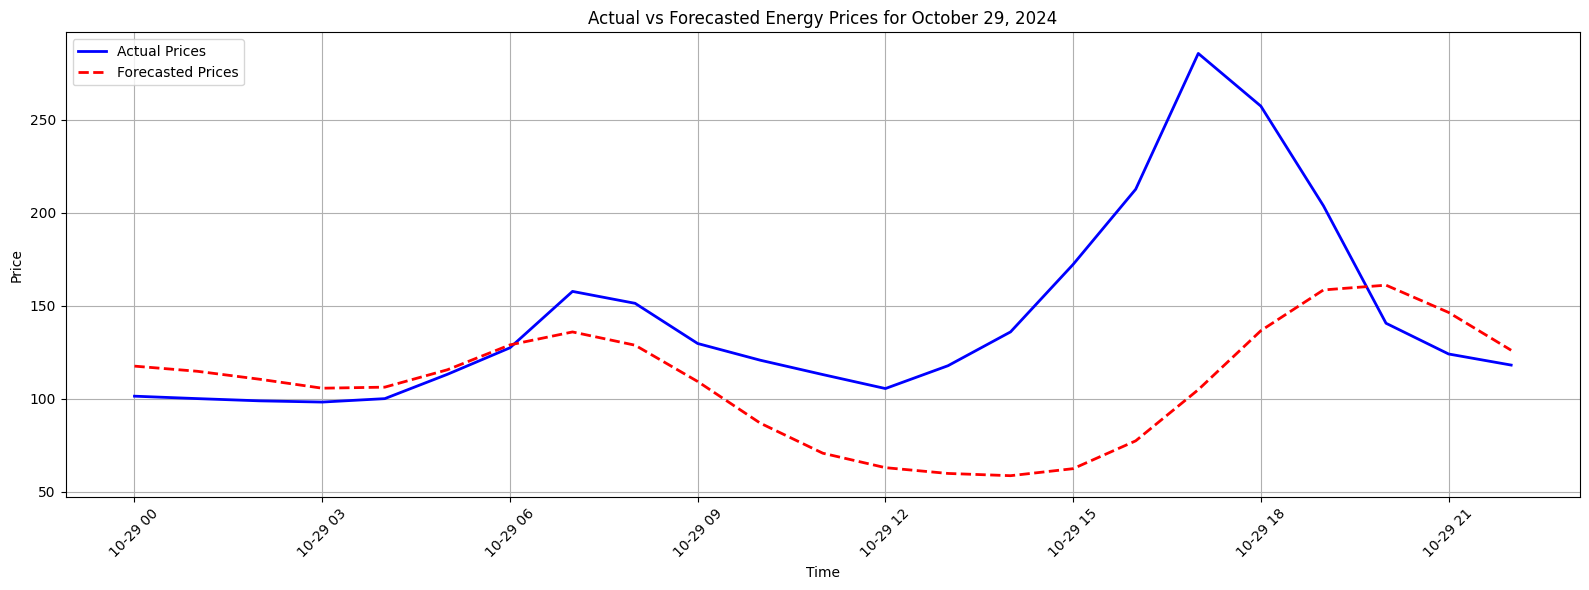

In [4]:
# Plot the forecasted vs actual values for October 29, 2024
plt.figure(figsize=(16, 6))
plt.plot(future_df['ds'], future_df['y'], label='Actual Prices', color='blue', linewidth=2)
plt.plot(future_df['ds'], future_df['yhat'], label='Forecasted Prices', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Forecasted Energy Prices for October 29, 2024")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Fourier Order (including Actual Data)

In [ ]:
# Load and prepare the dataset
df = pd.read_csv('/Users/zeynepkaya/PycharmProjects/LSDI-Project-/data/day_ahead_energy_prices.csv', parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)

# Sort dataframe by date in descending order
df = df.sort_values(by='Datetime', ascending=False).reset_index(drop=True)

# Filter data up to 30th October 2024
df = df[df['Datetime'] <= '2024-10-29 23:59:00']

# Filter data for the last 6 months
end_date = df['Datetime'].max()
start_date = end_date - timedelta(days=180)
df = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)].reset_index(drop=True)

# Rename columns to fit Prophet requirements
df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)
# actual 29th October 2024
actual_29th = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]

#outliers clipped
upper_threshold = (df['y'].mean() + 3 * df['y'].std())  # upper threshold
lower_threshold = df['y'].mean() - 3 * df['y'].std()  # lower threshold

# Clip outliers
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)

In [ ]:
model = Prophet(
 #   growth= 'linear',
 #   daily_seasonality=True,  # Turn off daily seasonality (add custom seasonality)
 #   yearly_seasonality=True,  # Allow yearly seasonality for longer trends
    weekly_seasonality=True,  # Allow weekly seasonality
 #   changepoint_prior_scale=0.05, # Default changepoint flexibility
    n_changepoints= 7,
 #   seasonality_mode= 'additive',
 #   seasonality_prior_scale = 0.01,
 #   holidays_prior_scale = 0.01,

)
# Adding custom seasonalities
model.add_seasonality(name='hourly', period=1, fourier_order=480)
model.add_seasonality(name='daily', period=24, fourier_order=50)
#model.add_seasonality(name='weekly', period=7*24, fourier_order=7)
model.add_seasonality(name='monthly', period=30.5*24, fourier_order=500)
model.add_seasonality(name='yearly', period=365.25, fourier_order=1000)

# Fit the model
model.fit(df)
future = pd.date_range(start='2024-10-29 00:00:00', end='2024-10-29 23:59:00', freq='h')
future_df = pd.DataFrame({'ds': future})

In [7]:
# RMSE
# Forecast the future values
forecast = model.predict(future_df)

# Merge actual and forecast data for October 29th
actual_29th = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
merged_data = pd.merge(actual_29th[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Calculate RMSE for October 29th
rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for October 29th, 2024: {rmse}")

RMSE for October 29th, 2024: 5.753559566263798


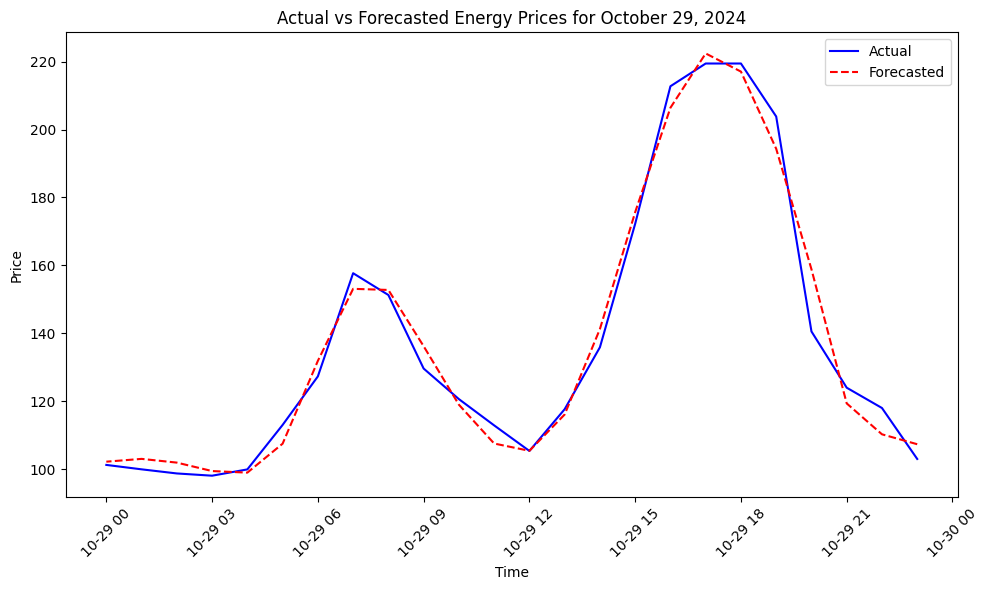

RMSE for October 29th, 2024: 5.753559566263798


In [8]:
# Plot the forecast vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(merged_data['ds'], merged_data['y'], label='Actual', color='blue')
plt.plot(merged_data['ds'], merged_data['yhat'], label='Forecasted', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for October 29, 2024")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Print the RMSE
print(f"RMSE for October 29th, 2024: {rmse}")

In [9]:
# Pickle the model
from datetime import datetime
import pickle
import os
import matplotlib.pyplot as plt
import json

# Create timestamp for unique folder naming
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
rmse_str = f"{rmse:.2f}"  # Format RMSE with two decimal points

# Define directory for this model
base_dir = '/Users/zeynepkaya/PycharmProjects/LSDI-Project-/models/Prophet/pickle'
model_dir = os.path.join(base_dir, f"model_{rmse_str}_rmse_{ts}")
os.makedirs(model_dir, exist_ok=True)

# Save Prophet model to the directory
pickle_path = os.path.join(model_dir, 'model.pickle')
with open(pickle_path, "wb") as file:
    pickle.dump(model, file)

# Collect all hyperparameters from the model
hyperparams = {
    'growth': model.growth,
    'changepoint_prior_scale': model.changepoint_prior_scale,
    'seasonality_mode': model.seasonality_mode,
    'daily_seasonality': model.daily_seasonality,
    'yearly_seasonality': model.yearly_seasonality,
    'weekly_seasonality': model.weekly_seasonality,
    'seasonality_prior_scale': model.seasonality_prior_scale,
    'holidays_prior_scale': model.holidays_prior_scale,
    'n_changepoints': model.n_changepoints,
    'seasonalities': model.seasonalities,  # Custom seasonalities
    'holidays': model.holidays.to_json() if model.holidays is not None else None  # Convert holidays to JSON if present
}

# Save hyperparameters to JSON file
json_path = os.path.join(model_dir, 'hyperparams.json')
with open(json_path, 'w') as json_file:
    json.dump(hyperparams, json_file, indent=4)

# Plot Actual vs Forecasted and save
plt.figure(figsize=(10, 6))
plt.plot(merged_data['ds'], merged_data['y'], label='Actual', color='blue')
plt.plot(merged_data['ds'], merged_data['yhat'], label='Forecasted', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for October 29, 2024")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Save the plot as an image
plot_path = os.path.join(model_dir, 'actual_vs_forecast.png')
plt.savefig(plot_path)
plt.close()


# Train/Test & Fourier Order *NOT including Actual Data

In [10]:
# Load and prepare the dataset
df = pd.read_csv('../../data/day_ahead_energy_prices.csv', parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
df = df.sort_values(by='Datetime', ascending=False).reset_index(drop=True)

df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)

# Keep 29th october actual data
#actual_data = df[df['ds'] <= '2024-10-29 23:59:00']

# Filter data up to 30th October 2024
df = df[df['ds'] <= '2024-10-29 23:59:00']
end_date = df['ds'].max()
start_date = end_date - timedelta(days=180)
df = df[(df['ds'] >= start_date) & (df['ds'] <= end_date)].reset_index(drop=True)

#outliers clipped
upper_threshold = (df['y'].mean() + 3 * df['y'].std())  # upper threshold
lower_threshold = df['y'].mean() - 3 * df['y'].std()  # lower threshold

# Clip outliers
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)

# Split data: Use the last 20% as test data, and the first 80% as training data
split_index = int(len(df) * 0.2)  # 80% for training, 20% for testing
test_data = df[:split_index]  # First 80% for training
train_data = df[split_index:]   # Remaining 20% for testing


### The Prophet Model

In [ ]:
# Initialize and configure the Prophet model
model = Prophet(
    growth= 'linear',
    daily_seasonality=False, # Turn off daily seasonality (add custom seasonality)
   # yearly_seasonality=True,  # Allow yearly seasonality for longer trends
   # weekly_seasonality=True,  # Allow weekly seasonality
    changepoint_prior_scale= 0.5, # Default changepoint flexibility
    n_changepoints= 5,
    seasonality_mode= 'additive',
    seasonality_prior_scale = 0.01,
    holidays_prior_scale = 0.01,

)

# Add custom seasonalities
model.add_seasonality(name='hourly', period=1, fourier_order=2)
model.add_seasonality(name='daily', period=24, fourier_order=12)
model.add_seasonality(name='weekly', period=7*24, fourier_order=1)
model.add_seasonality(name='monthly', period=30.5*24, fourier_order=30)
model.add_seasonality(name='yearly', period=365.25*24, fourier_order=1)

# Fit the model on the training data
model.fit(train_data)

# Define future dates for forecasting (test period)
future_df = test_data[['ds']]  # Using the test data for future forecasting

# Forecast the future values (test period)
forecast = model.predict(future_df)

In [12]:
#RMSE
# Merge actual and forecast data for comparison
merged_data = pd.merge(test_data[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Filter merged_data to include only the data for 29th October 2024
merged_data_29th = merged_data[(merged_data['ds'] >= '2024-10-29 00:00:00') & (merged_data['ds'] <= '2024-10-29 23:59:59')]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for the test period: {rmse}")

rmse_29th_october = np.sqrt(mean_squared_error(merged_data_29th['y'], merged_data_29th['yhat']))
print(f"RMSE for 29th October 2024: {rmse_29th_october}")



RMSE for the test period: 54.68512500029602
RMSE for 29th October 2024: 44.82103705085119


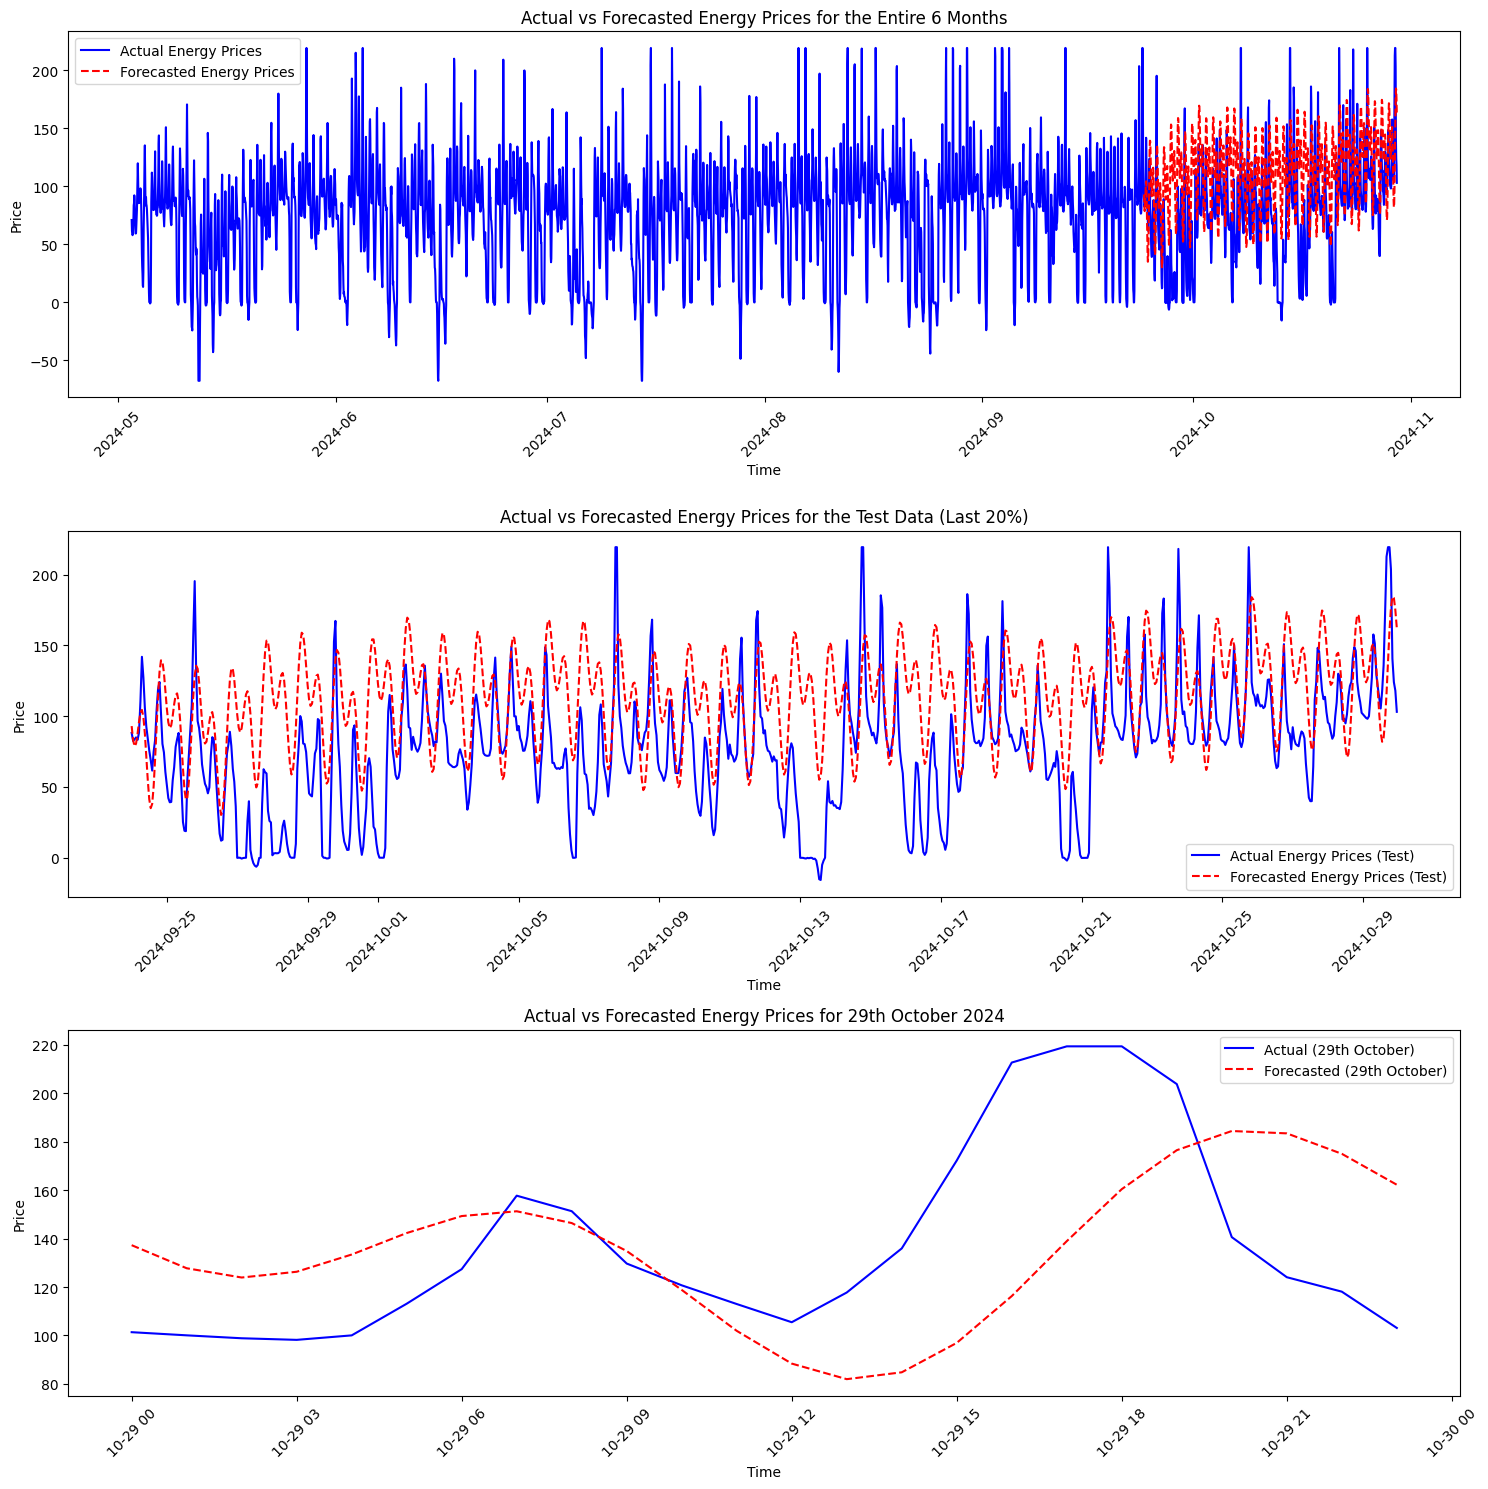

In [13]:
# Plot the entire data with forecasted and actual values
plt.figure(figsize=(15, 15))

# Plot entire data (train + test) with forecast and actual values
plt.subplot(3, 1, 1)
plt.plot(df['ds'], df['y'], label='Actual Energy Prices', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for the Entire 6 Months")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Plot only test data (last 20%)
plt.subplot(3, 1, 2)
plt.plot(test_data['ds'], test_data['y'], label='Actual Energy Prices (Test)', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices (Test)', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for the Test Data (Last 20%)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Plot 29th October 2024 data separately
october_29th_data = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
forecast_29th_october = forecast[forecast['ds'].isin(october_29th_data['ds'])]

plt.subplot(3, 1, 3)
plt.plot(october_29th_data['ds'], october_29th_data['y'], label='Actual (29th October)', color='blue')
plt.plot(forecast_29th_october['ds'], forecast_29th_october['yhat'], label='Forecasted (29th October)', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for 29th October 2024")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()


plt.tight_layout()
plt.show()


In [14]:
# pickle
from datetime import datetime
import pickle
import os
import matplotlib.pyplot as plt
import json

# Create timestamp for unique folder naming
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
rmse_str = f"{rmse_29th_october:.2f}"  # Format RMSE with two decimal points

# Define directory for this model
base_dir = '/Users/zeynepkaya/PycharmProjects/LSDI-Project-/models/Prophet/pickle'
model_dir = os.path.join(base_dir, f"model_{rmse_str}_rmse_{ts}")
os.makedirs(model_dir, exist_ok=True)

# Save Prophet model to the directory
pickle_path = os.path.join(model_dir, 'model.pickle')
with open(pickle_path, "wb") as file:
    pickle.dump(model, file)

# Collect all hyperparameters from the model
hyperparams = {
    'growth': model.growth,
    'changepoint_prior_scale': model.changepoint_prior_scale,
    'seasonality_mode': model.seasonality_mode,
    'daily_seasonality': model.daily_seasonality,
    'yearly_seasonality': model.yearly_seasonality,
    'weekly_seasonality': model.weekly_seasonality,
    'seasonality_prior_scale': model.seasonality_prior_scale,
    'holidays_prior_scale': model.holidays_prior_scale,
    'n_changepoints': model.n_changepoints,
    'seasonalities': model.seasonalities,  # Custom seasonalities
    'holidays': model.holidays.to_json() if model.holidays is not None else None  # Convert holidays to JSON if present
}

# Save hyperparameters to JSON file
json_path = os.path.join(model_dir, 'hyperparams.json')
with open(json_path, 'w') as json_file:
    json.dump(hyperparams, json_file, indent=4)

# Plot Entire 6 Months with Forecasted and Actual Values
plt.figure(figsize=(15, 20))
plt.subplot(3, 1, 1)
plt.plot(df['ds'], df['y'], label='Actual Energy Prices', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for the Entire 6 Months")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Plot Test Data with Forecasted and Actual Values
plt.subplot(3, 1, 2)
plt.plot(test_data['ds'], test_data['y'], label='Actual Energy Prices (Test)', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices (Test)', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for the Test Data (Last 20%)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Plot 29th October 2024 Data
october_29th_data = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
forecast_29th_october = forecast[forecast['ds'].isin(october_29th_data['ds'])]

plt.subplot(3, 1, 3)
plt.plot(october_29th_data['ds'], october_29th_data['y'], label='Actual (29th October)', color='blue')
plt.plot(forecast_29th_october['ds'], forecast_29th_october['yhat'], label='Forecasted (29th October)', color='red', linestyle='dashed')
plt.title("Actual vs Forecasted Energy Prices for 29th October 2024")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

# Save the third plot
plot_path_29october = os.path.join(model_dir, 'actual_vs_forecast_29october.png')
plt.savefig(plot_path_29october)

# Ensure the layout is tight before closing
plt.tight_layout()
plt.close()

# Final print statement
print("All plots have been saved successfully.")


All plots have been saved successfully.


# Logistic growth

In [ ]:
# Add a carrying capacity column (20% above max observed value)
df['cap'] = df['y'].max()

# Initialize and configure the Prophet model with logistic growth
model = Prophet(
    growth='logistic',  # Set logistic growth
    daily_seasonality=False,  # Turn off daily seasonality (add custom seasonality)
    changepoint_prior_scale=0.5,  # Default changepoint flexibility
    n_changepoints=5,
    seasonality_mode='additive',
    seasonality_prior_scale=0.01,
    holidays_prior_scale=0.01,
)

# Add custom seasonalities
model.add_seasonality(name='hourly', period=1, fourier_order=2)
model.add_seasonality(name='daily', period=24, fourier_order=12)
model.add_seasonality(name='weekly', period=7*24, fourier_order=1)
model.add_seasonality(name='monthly', period=30.5*24, fourier_order=30)
model.add_seasonality(name='yearly', period=365.25*24, fourier_order=1)

# Add the 'cap' column to the training data
train_data['cap'] = df['cap'].iloc[0]  # Use the same cap for all rows in the training data

# Fit the model on the training data
model.fit(train_data)

# Define future dates for forecasting (test period)
future_df = test_data[['ds']]  # Using the test data for future forecasting

# Add the 'cap' column to the future data
future_df['cap'] = df['cap'].iloc[0]  # Ensure the 'cap' value is the same as in the training data

# Forecast the future values (test period)
forecast = model.predict(future_df)

# Display the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
# RMSE Calculation for the Test Period
merged_data = pd.merge(test_data[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')

# Filter merged_data to include only the data for 29th October 2024
merged_data_29th = merged_data[(merged_data['ds'] >= '2024-10-29 00:00:00') & (merged_data['ds'] <= '2024-10-29 23:59:59')]

In [16]:
#RMSE  #linear is better.
# Calculate RMSE for the entire test period
rmse = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for the test period: {rmse}")

# Calculate RMSE for 29th October 2024
rmse_29th_october = np.sqrt(mean_squared_error(merged_data_29th['y'], merged_data_29th['yhat']))
print(f"RMSE for 29th October 2024: {rmse_29th_october}")


RMSE for the test period: 46.237231655005694
RMSE for 29th October 2024: 55.56881448335611


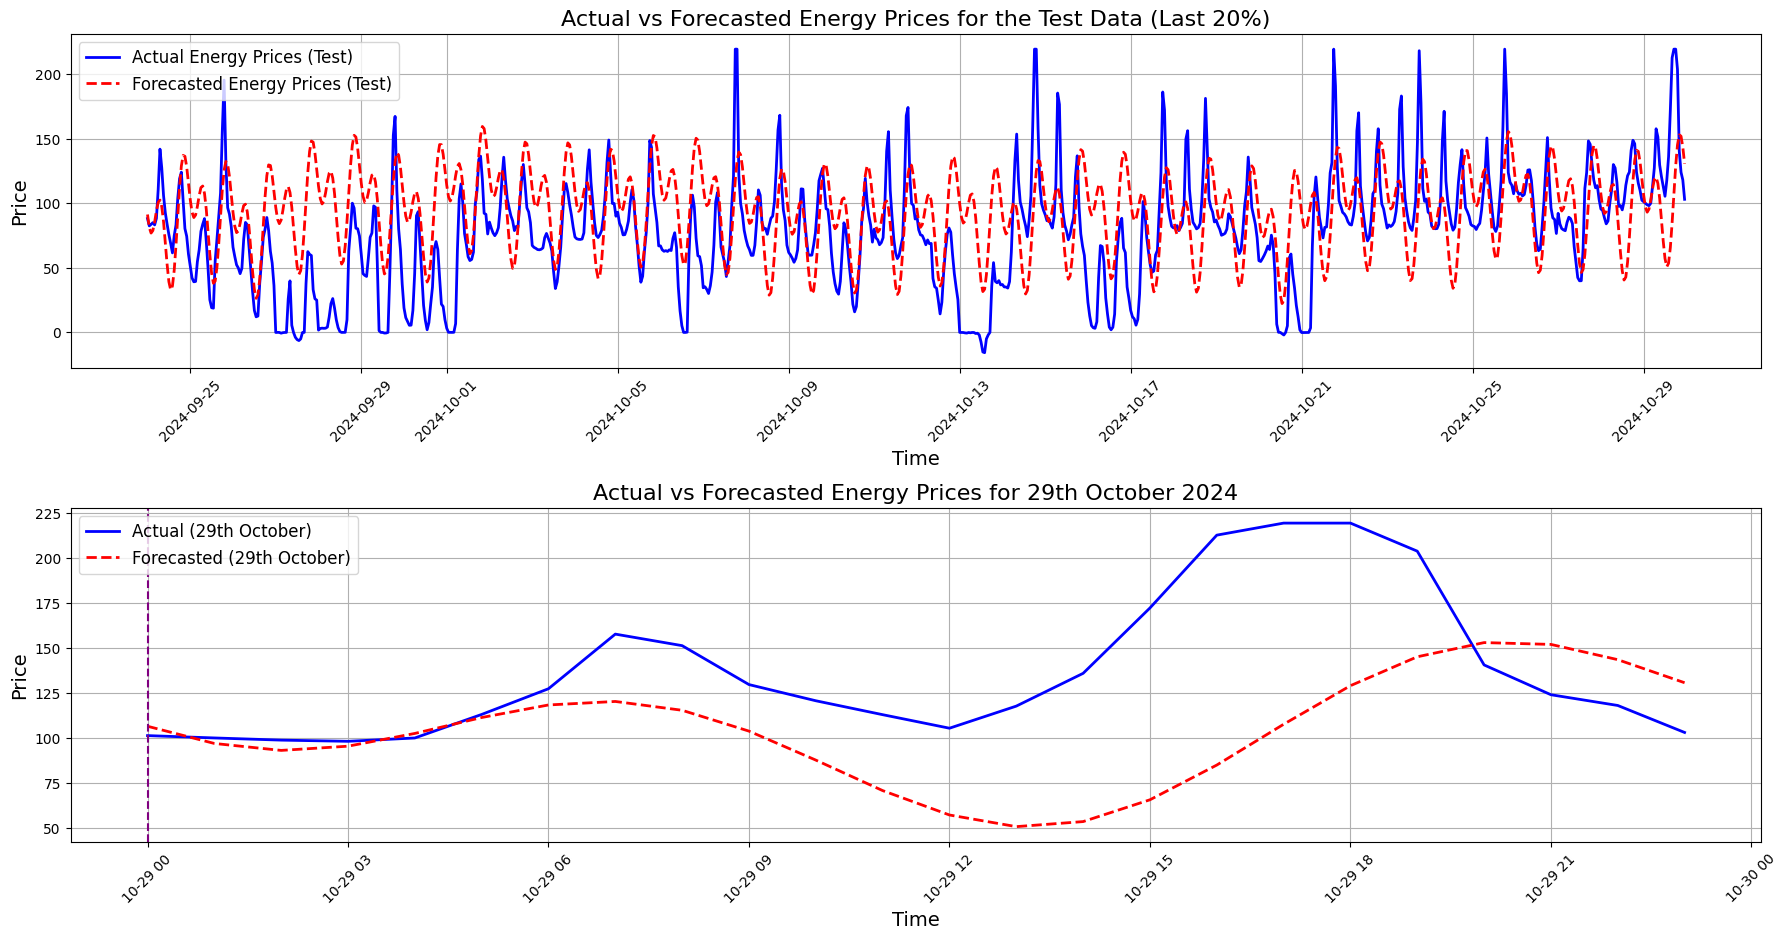

In [17]:
# Set up a larger figure size for better clarity
plt.figure(figsize=(18, 14))  # Larger figure to accommodate all plots cleanly

# # Plot the entire data (train + test) with forecasted and actual values
# plt.subplot(3, 1, 1)
# plt.plot(df['ds'], df['y'], label='Actual Energy Prices', color='blue', linewidth=2)
# plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices', color='red', linestyle='dashed', linewidth=2)
# plt.title("Actual vs Forecasted Energy Prices for the Entire 6 Months", fontsize=16)
# plt.xlabel("Time", fontsize=14)
# plt.ylabel("Price", fontsize=14)
# plt.xticks(rotation=45)
# plt.legend(loc='upper left', fontsize=12)
# plt.grid(True)

# Plot only the test data (last 20%)
plt.subplot(3, 1, 2)
plt.plot(test_data['ds'], test_data['y'], label='Actual Energy Prices (Test)', color='blue', linewidth=2)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Energy Prices (Test)', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Forecasted Energy Prices for the Test Data (Last 20%)", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

# Plot 29th October 2024 data separately
october_29th_data = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
forecast_29th_october = forecast[forecast['ds'].isin(october_29th_data['ds'])]

plt.subplot(3, 1, 3)
plt.plot(october_29th_data['ds'], october_29th_data['y'], label='Actual (29th October)', color='blue', linewidth=2)
plt.plot(forecast_29th_october['ds'], forecast_29th_october['yhat'], label='Forecasted (29th October)', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Forecasted Energy Prices for 29th October 2024", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

# Adjust vertical space between the subplots
plt.subplots_adjust(hspace=0.4)  # Increase spacing between subplots


# Optional: Adding a vertical line for 29th October 2024
plt.axvline(pd.to_datetime('2024-10-29'), color='purple', linestyle='--', label='29th October 2024')

# Tighten layout to avoid clipping
plt.tight_layout()

# Show the final plots
plt.show()


# Modeling COVID-19 lockdowns, Holidays and Special Events
whole data

In [18]:
# Load and prepare the dataset
df = pd.read_csv('../../data/day_ahead_energy_prices.csv', parse_dates=['Datetime'])
df['Datetime'] = df['Datetime'].dt.tz_localize(None)
df = df.sort_values(by='Datetime', ascending=False).reset_index(drop=True)

df.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'}, inplace=True)

# Filter data up to 30th October 2024
df = df[df['ds'] <= '2024-10-29 23:59:00']
# end_date = df['ds'].max()
# start_date = end_date - timedelta(days=180)
# df = df[(df['ds'] >= start_date) & (df['ds'] <= end_date)].reset_index(drop=True)

# Clip outliers
upper_threshold = (df['y'].mean() + 3 * df['y'].std())  # upper threshold
lower_threshold = df['y'].mean() - 3 * df['y'].std()  # lower threshold

# Clip outliers
df['y'] = df['y'].clip(lower=lower_threshold, upper=upper_threshold)

# Split data: Use the last 20% as test data, and the first 80% as training data
split_index = int(len(df) * 0.2)  # 80% for training, 20% for testing
test_data = df[:split_index]  # First 80% for training
train_data = df[split_index:]   # Remaining 20% for testing

In [73]:
# Define the lockdowns as one-off holidays
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'}, #Covid 19
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    {'holiday': 'war',        'ds': '2022-08-24', 'lower_window': 0, 'ds_upper': '2023-08-10'}, #ukrain war
])

# Convert to datetime
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])

lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

# Initialize and configure the Prophet model with holidays (lockdowns and special events)
model_with_holidays = Prophet(
    growth='linear',
    daily_seasonality=True,
    changepoint_prior_scale=0.5,
    n_changepoints=5,
    seasonality_mode='additive',
    seasonality_prior_scale=0.01,
    holidays_prior_scale=0.01,
    holidays=lockdowns  # Add lockdowns as holidays
)

# Add custom seasonalities (if necessary)
model_with_holidays.add_seasonality(name='hourly', period=1, fourier_order=2)
model_with_holidays.add_seasonality(name='daily', period=24, fourier_order=12)
model_with_holidays.add_seasonality(name='weekly', period=7*24, fourier_order=1)
model_with_holidays.add_seasonality(name='monthly', period=30.5*24, fourier_order=30)
model_with_holidays.add_seasonality(name='yearly', period=365.25*24, fourier_order=1)

# Fit the model with holidays
model_with_holidays.fit(train_data)

# Forecast the future values (test period)
future_df = test_data[['ds']]  # Using the test data for future forecasting
forecast_with_holidays = model_with_holidays.predict(future_df)

09:56:51 - cmdstanpy - INFO - Chain [1] start processing
09:57:10 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# RMSE Calculation
merged_data_with_holidays = pd.merge(test_data[['ds', 'y']], forecast_with_holidays[['ds', 'yhat']], on='ds', how='inner')

# Filter merged_data to include only the data for 29th October 2024
merged_data_29th = merged_data_with_holidays[(merged_data_with_holidays['ds'] >= '2024-10-29 00:00:00') & (merged_data_with_holidays['ds'] <= '2024-10-29 23:59:59')]

# Calculate RMSE for the entire test period
rmse = np.sqrt(mean_squared_error(merged_data_with_holidays['y'], merged_data_with_holidays['yhat']))
print(f"RMSE for the test period (with holidays): {rmse}")

# Calculate RMSE for 29th October 2024
rmse_29th_october = np.sqrt(mean_squared_error(merged_data_29th['y'], merged_data_29th['yhat']))
print(f"RMSE for 29th October 2024 (with holidays): {rmse_29th_october}")

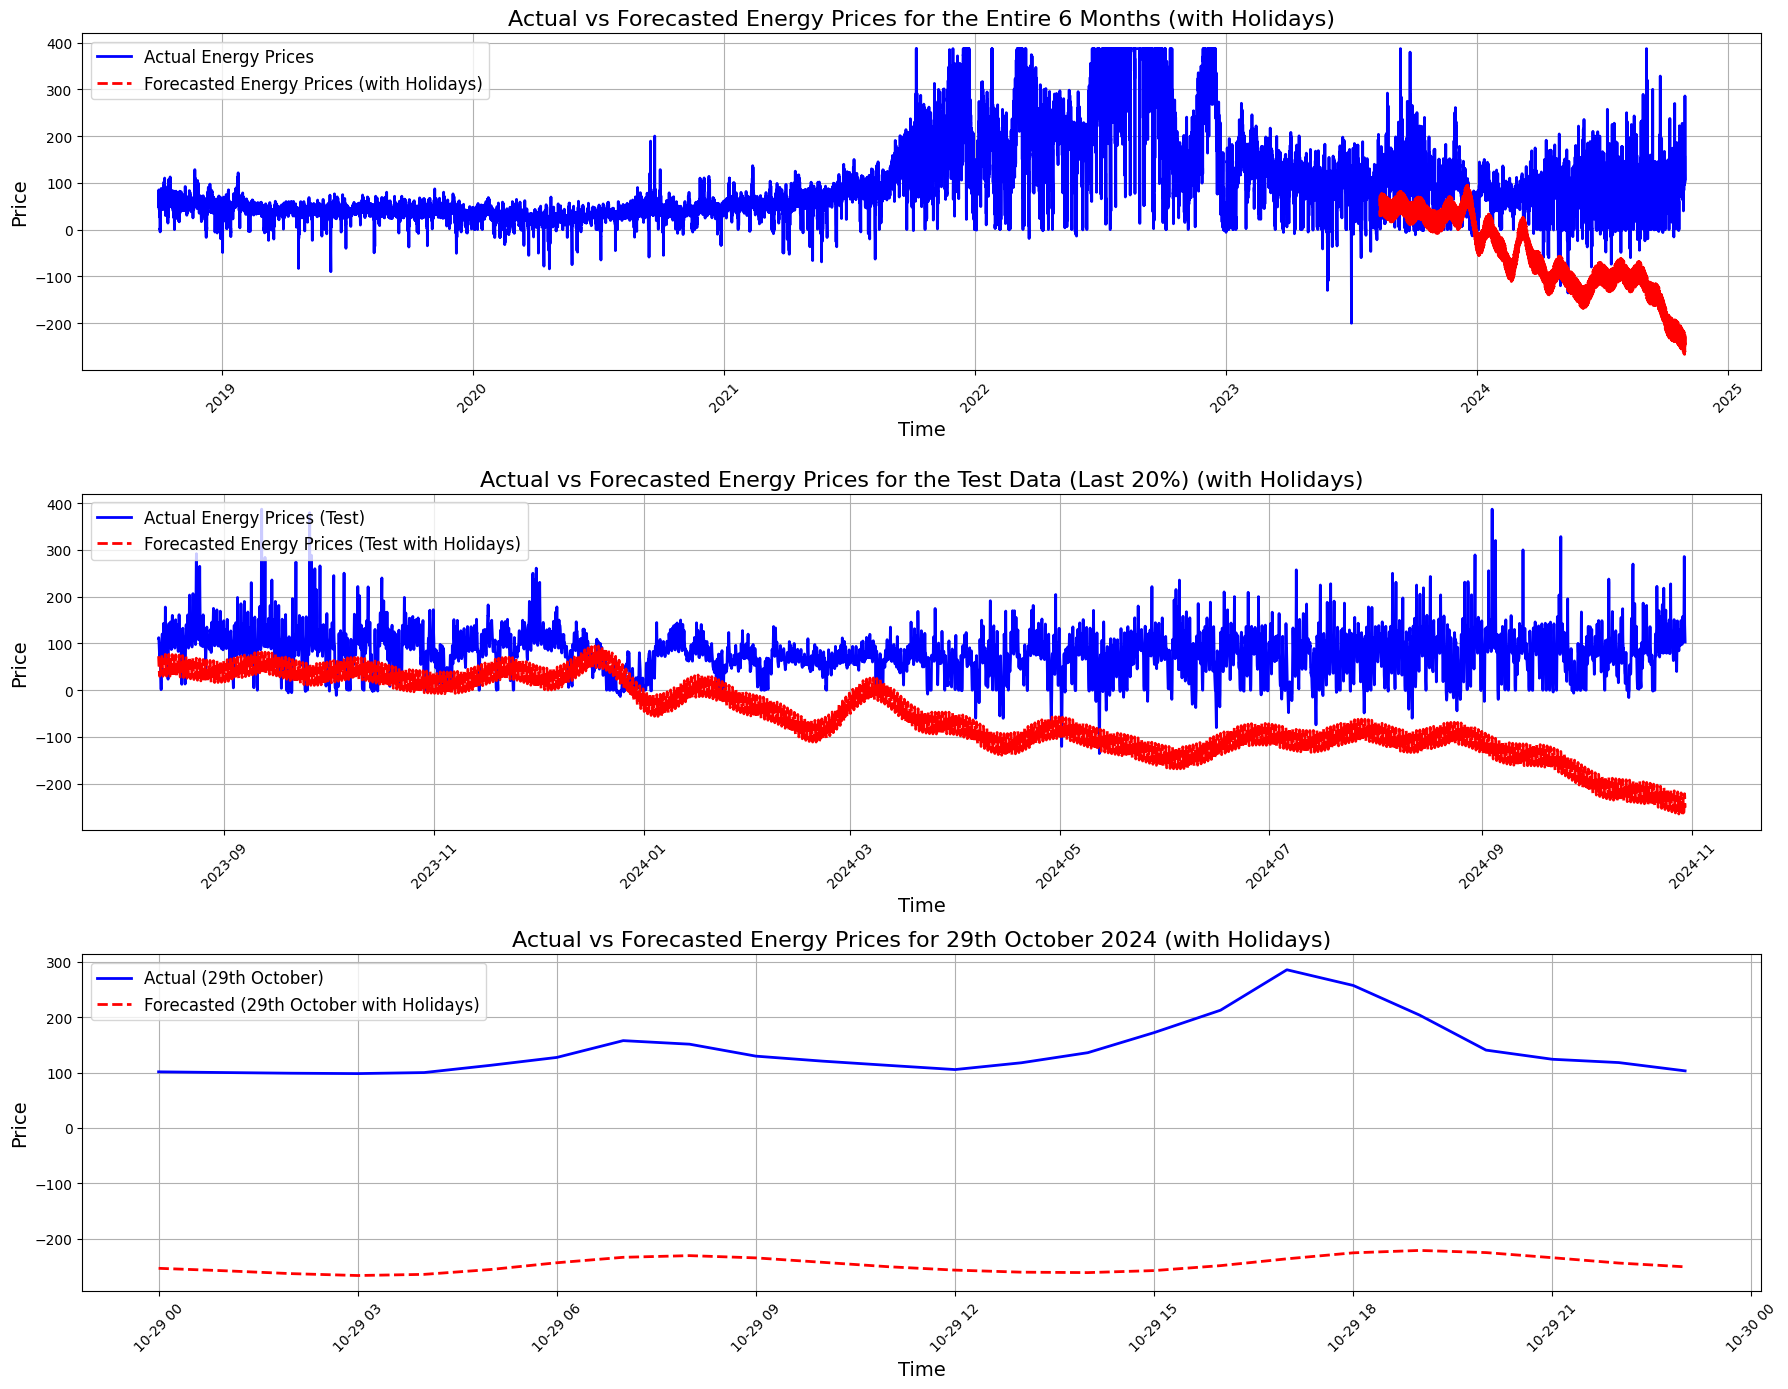

In [21]:
# Plot the entire data with forecasted and actual values
plt.figure(figsize=(18, 14))

# Plot entire data (train + test) with forecast and actual values
plt.subplot(3, 1, 1)
plt.plot(df['ds'], df['y'], label='Actual Energy Prices', color='blue', linewidth=2)
plt.plot(forecast_with_holidays['ds'], forecast_with_holidays['yhat'], label='Forecasted Energy Prices (with Holidays)', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Forecasted Energy Prices for the Entire 6 Months (with Holidays)", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

# Plot only the test data (last 20%)
plt.subplot(3, 1, 2)
plt.plot(test_data['ds'], test_data['y'], label='Actual Energy Prices (Test)', color='blue', linewidth=2)
plt.plot(forecast_with_holidays['ds'], forecast_with_holidays['yhat'], label='Forecasted Energy Prices (Test with Holidays)', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Forecasted Energy Prices for the Test Data (Last 20%) (with Holidays)", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

# Plot 29th October 2024 data separately
october_29th_data = df[(df['ds'] >= '2024-10-29 00:00:00') & (df['ds'] <= '2024-10-29 23:59:59')]
forecast_29th_october = forecast_with_holidays[forecast_with_holidays['ds'].isin(october_29th_data['ds'])]

plt.subplot(3, 1, 3)
plt.plot(october_29th_data['ds'], october_29th_data['y'], label='Actual (29th October)', color='blue', linewidth=2)
plt.plot(forecast_29th_october['ds'], forecast_29th_october['yhat'], label='Forecasted (29th October with Holidays)', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Forecasted Energy Prices for 29th October 2024 (with Holidays)", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


# Create Features


In [24]:
# Load energy prices data
energy_data = pd.read_csv('../../data/day_ahead_energy_prices.csv')
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']).dt.tz_localize(None)  # Convert to datetime and remove timezone
energy_data = energy_data.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'})  # Rename columns to match Prophet's expected column names

weather_data = pd.read_csv('../../data/germany_weather_average.csv')  # Adjust file path if needed
weather_data['date'] = pd.to_datetime(weather_data['date']).dt.tz_localize(None)
weather_data.rename(columns={'date': 'ds'}, inplace=True)

market_mix = pd.read_csv('../../data/hourly_market_mix_cleaned.csv')
market_mix['Timestamp'] = pd.to_datetime(market_mix['Timestamp']).dt.tz_localize(None)
market_mix.rename(columns={'Timestamp': 'ds'}, inplace=True)
market_mix = market_mix.ffill()

merged_data = pd.merge(market_mix, energy_data, on='ds', how='left')
merged_data = pd.merge(merged_data, weather_data, on= 'ds' , how= 'left')


In [25]:
# Feature engineering function
def create_features(df, include_target=True):
    df = df.copy()
    df['hour'] = df['ds'].dt.hour
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['weekofyear'] = df['ds'].dt.isocalendar().week

    if include_target:
        # Moving averages for hours (only if 'y' is available)
        for window in [3, 6, 12]:  # hours
            df[f'ma_{int(window)}_hours'] = df['y'].rolling(window=window).mean()

        # Moving averages for days (1 day, 3 days, 1 week)
        for window in [24, 72, 168]:  # days
            df[f'ma_{int(window / 24)}_days'] = df['y'].rolling(window=window).mean()

        # Moving averages for months (assuming 30 days per months
        for window in [1, 2, 3]:  # months
            hours_in_month = window * 30 * 24
            df[f'ma_{int(window)}_month'] = df['y'].rolling(window=hours_in_month).mean()

        # Fill NaN values in the moving averages with the median of each column
        for column in df.columns:
            if column.startswith('ma_'):  # Only apply to moving average columns
                df[column] = df[column].fillna(df[column].median())

    return df

energy_data = create_features(energy_data)
energy_data['weekofyear'] = energy_data['weekofyear'].astype('int64')

split_index = int(len(energy_data) * 0.82)
test_split_index = split_index + len(energy_data[split_index:]) // 2
train_data = energy_data[:split_index]
validation_data = energy_data[split_index:test_split_index]
test_data = energy_data[test_split_index:]

In [26]:
# # Select required columns for Prophet
# train_data = train_data[['ds', 'y', 'dayofweek', 'dayofyear', 'weekofyear',
#                          'ma_3_hours', 'ma_6_hours', 'ma_12_hours',
#                          'ma_1_days', 'ma_3_days', 'ma_7_days',
#                          'ma_1_month', 'ma_2_month', 'ma_3_month' ]]
# future_df = test_data[['ds', 'dayofweek', 'dayofyear', 'weekofyear',
#                        'ma_3_hours', 'ma_6_hours', 'ma_12_hours',
#                        'ma_1_days', 'ma_3_days', 'ma_7_days',
#                         'ma_1_month', 'ma_2_month', 'ma_3_month' ]]


# Fit and predict
model = Prophet()
#model.add_regressor('ma_2_month')
#model.add_regressor('ma_3_month')
#model.add_regressor('ma_1_month')
model.add_regressor('dayofweek')
model.add_regressor('dayofyear')
#model.add_regressor('weekofyear')
model.add_regressor('ma_3_hours')
model.add_regressor('ma_6_hours')
model.add_regressor('ma_12_hours')
model.add_regressor('ma_1_days')
model.add_regressor('ma_3_days')
model.add_regressor('ma_7_days')
# Fit model
model.fit(train_data)

future = create_features(test_data, include_target=False)  # No need to include target 'y' for future data
forecast = model.predict(future)
predicted_prices = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

#  RMSE for the entire test data (last 20%)
merged_test_data = pd.merge(test_data[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')
rmse_test = np.sqrt(mean_squared_error(merged_test_data['y'], merged_test_data['yhat']))
print(f"RMSE for the entire test data: {rmse_test}")


22:01:17 - cmdstanpy - INFO - Chain [1] start processing
22:01:20 - cmdstanpy - INFO - Chain [1] done processing


RMSE for the entire test data: 16.541142360917895


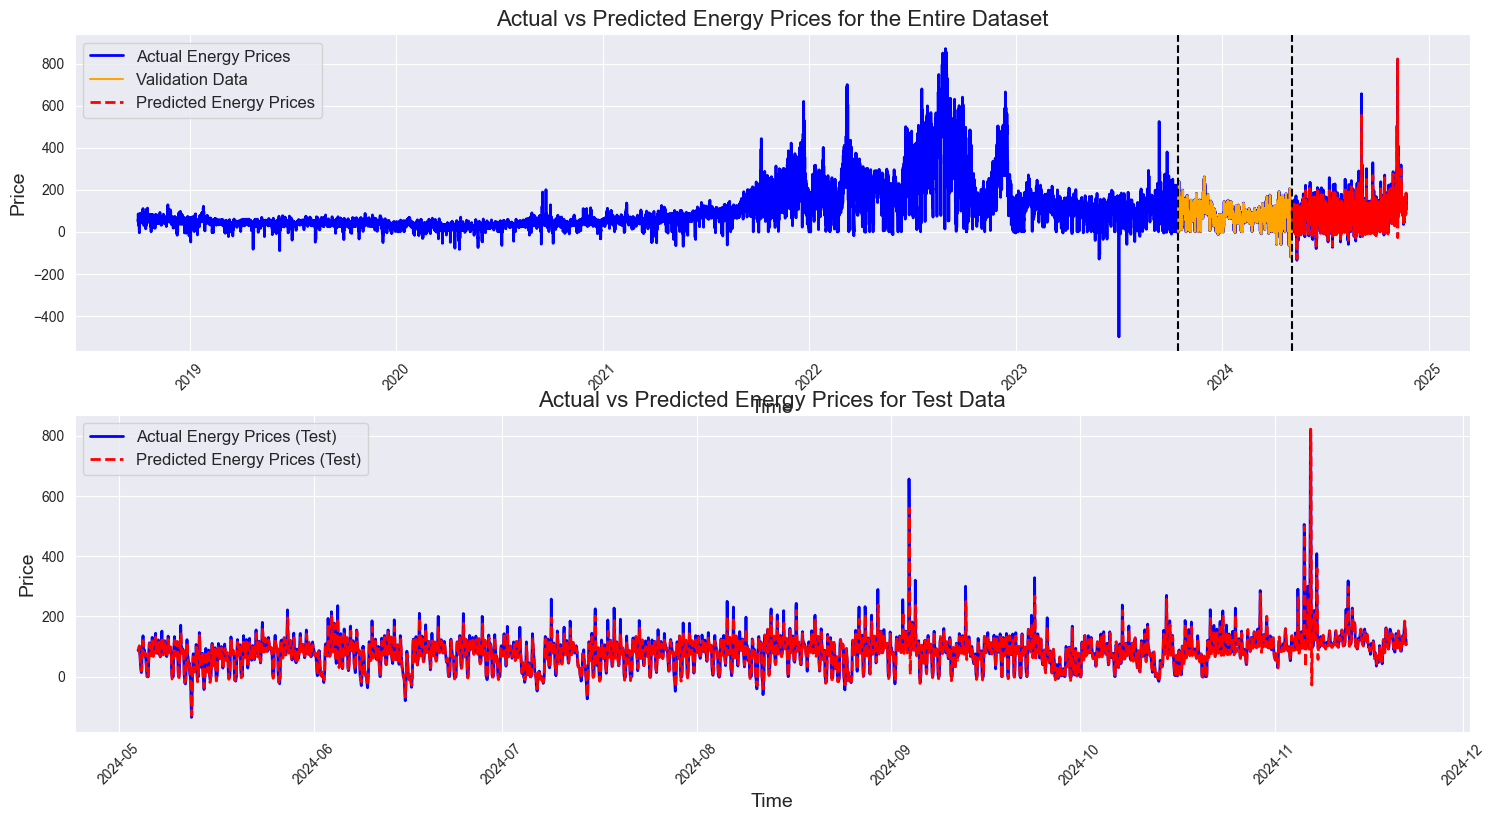

In [30]:
plt.figure(figsize=(18, 14))

# 1st Plot: Actual and predicted values for the entire dataset (training + test)
plt.subplot(3, 1, 1)
plt.plot(energy_data['ds'], energy_data['y'], label='Actual Energy Prices', color='blue', linewidth=2)
plt.plot(validation_data['ds'], validation_data['y'], label='Validation Data', color='orange')
plt.plot(predicted_prices['ds'], predicted_prices['yhat'], label='Predicted Energy Prices', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Predicted Energy Prices for the Entire Dataset", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

# Add vertical lines to separate train, validation, and test data
plt.axvline(x=train_data['ds'].iloc[-1], color='black',  linestyle='--')
plt.axvline(x=validation_data['ds'].iloc[-1], color='black', linestyle='--')


# 2nd Plot: Actual and predicted values for only the test data
plt.subplot(3, 1, 2)
plt.plot(test_data['ds'], test_data['y'], label='Actual Energy Prices (Test)', color='blue', linewidth=2)
plt.plot(predicted_prices['ds'], predicted_prices['yhat'], label='Predicted Energy Prices (Test)', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Predicted Energy Prices for Test Data", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)


# Add weather data

In [40]:
energy_data = pd.read_csv('../../data/day_ahead_energy_prices.csv')
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']).dt.tz_localize(None)  # Convert to datetime and remove timezone
energy_data = energy_data.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'})  # Rename columns to match Prophet's expected column names

weather_data = pd.read_csv('../../data/germany_weather_average.csv')  # Adjust file path if needed
weather_data['date'] = pd.to_datetime(weather_data['date']).dt.tz_localize(None)
weather_data.rename(columns={'date': 'ds'}, inplace=True)

merged_data = pd.merge(energy_data, weather_data, on='ds', how='left')
merged_data = create_features(merged_data)

split_index = int(len(merged_data) * 0.82)
test_split_index = split_index + len(merged_data[split_index:]) // 2
train_data = merged_data[:split_index]
validation_data = merged_data[split_index:test_split_index]
test_data = merged_data[test_split_index:]

KeyError: 'Biomass'

In [33]:
model = Prophet()

# Add weather-related regressors
model.add_regressor('temperature_2m')
model.add_regressor('relative_humidity_2m')
model.add_regressor('Precipitation (rain/snow)')
model.add_regressor('surface_pressure')
model.add_regressor('cloud_cover')
model.add_regressor('wind_speed_100m')
model.add_regressor('sunshine_duration')
model.add_regressor('Global Horizontal Irradiance')
model.add_regressor('direct_radiation')

# Add moving average regressors
model.add_regressor('dayofweek')
model.add_regressor('dayofyear')
model.add_regressor('ma_3_hours')
model.add_regressor('ma_6_hours')
model.add_regressor('ma_12_hours')
model.add_regressor('ma_1_days')
model.add_regressor('ma_3_days')
model.add_regressor('ma_7_days')

# Fit the model on the training data
model.fit(train_data)

# Prepare the future dataframe (using the test data)
future = create_features(test_data, include_target=False)  # No need to include target 'y' for future data
forecast = model.predict(future)
predicted_prices = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

22:02:28 - cmdstanpy - INFO - Chain [1] start processing
22:02:39 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
# Calculate RMSE for the test period
merged_data = pd.merge(test_data[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')
rmse_test = np.sqrt(mean_squared_error(merged_data['y'], merged_data['yhat']))
print(f"RMSE for Test Period: {rmse_test}")

RMSE for Test Period: 16.253563795752154


# ++Add energy mix

In [181]:
def create_features(df, include_target= True):
    df = df.copy()

    # Extract temporal features
    df['hour'] = df['ds'].dt.hour
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['weekofyear'] = df['ds'].dt.isocalendar().week

    if include_target:
        # Moving averages for hours (only if 'y' is available)
        for window in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,17, 18, 19, 20, 21, 22, 23]:  # hours
            df[f'ma_{int(window)}_hours'] = df['y'].rolling(window=window).mean()

        # Moving averages for days (1 day, 3 days, 1 week)
        for window in [24, 72, 168]:  # days
            df[f'ma_{int(window / 24)}_days'] = df['y'].rolling(window=window).mean()

        # Moving averages for months (assuming 30 days per months
        for window in [1, 2, 3]:  # months
            hours_in_month = window * 30 * 24
            df[f'ma_{int(window)}_month'] = df['y'].rolling(window=hours_in_month).mean()
                # Rolling averages for multiple energy sources and the target variable

        for window in [3, 6, 12]:  # hours
            df[f'price_ma_{int(window)}_hours'] = df['y'].rolling(window=window).mean()
            df[f'biomass_ma_{int(window)}_hours'] = df['Biomass'].rolling(window=window).mean()
            df[f'pumped_storage_generation_ma_{int(window)}_hours'] = df['Pumped storage generation'].rolling(window=window).mean()
            df[f'hard_coal_ma_{int(window)}_hours'] = df['Hard Coal'].rolling(window=window).mean()
            df[f'lignite_ma_{int(window)}_hours'] = df['Lignite'].rolling(window=window).mean()
            df[f'natural_gas_ma_{int(window)}_hours'] = df['Natural Gas'].rolling(window=window).mean()
            df[f'nuclear_ma_{int(window)}_hours'] = df['Nuclear'].rolling(window=window).mean()
            df[f'other_ma_{int(window)}_hours'] = df['Other'].rolling(window=window).mean()
            df[f'solar_ma_{int(window)}_hours'] = df['Solar'].rolling(window=window).mean()
            df[f'wind_offshore_ma_{int(window)}_hours'] = df['Wind offshore'].rolling(window=window).mean()
            df[f'wind_onshore_ma_{int(window)}_hours'] = df['Wind onshore'].rolling(window=window).mean()

        for window in [24, 72, 168]:  # 1 day, 3 days, 1 week
            df[f'price_ma_{int(window / 24)}_days'] = df['y'].rolling(window=window).mean()
            df[f'biomass_ma_{int(window / 24)}_days'] = df['Biomass'].rolling(window=window).mean()
            df[f'pumped_storage_generation_ma_{int(window / 24)}_days'] = df['Pumped storage generation'].rolling(window=window).mean()
            df[f'hard_coal_ma_{int(window / 24)}_days'] = df['Hard Coal'].rolling(window=window).mean()
            df[f'lignite_ma_{int(window / 24)}_days'] = df['Lignite'].rolling(window=window).mean()
            df[f'natural_gas_ma_{int(window / 24)}_days'] = df['Natural Gas'].rolling(window=window).mean()
            df[f'nuclear_ma_{int(window / 24)}_days'] = df['Nuclear'].rolling(window=window).mean()
            df[f'other_ma_{int(window / 24)}_days'] = df['Other'].rolling(window=window).mean()
            df[f'solar_ma_{int(window / 24)}_days'] = df['Solar'].rolling(window=window).mean()
            df[f'wind_offshore_ma_{int(window / 24)}_days'] = df['Wind offshore'].rolling(window=window).mean()
            df[f'wind_onshore_ma_{int(window / 24)}_days'] = df['Wind onshore'].rolling(window=window).mean()

        # Fill NaN values in rolling averages with column medians
        for column in df.columns:
            if 'ma_' in column or column.startswith('price_ma_'):
                df[column] = df[column].interpolate(method='linear').fillna(df[column].median())


        return df


In [182]:
market_mix = pd.read_csv('../../data/hourly_market_mix_cleaned.csv')
market_mix['Timestamp'] = pd.to_datetime(market_mix['Timestamp']).dt.tz_localize(None)
market_mix.rename(columns={'Timestamp': 'ds'}, inplace=True)
market_mix = market_mix.ffill()

energy_data = pd.read_csv('../../data/day_ahead_energy_prices.csv')
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']).dt.tz_localize(None)
energy_data = energy_data.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'})

merged_data = pd.merge(market_mix, energy_data, on='ds', how='left')
merged_data = pd.merge(merged_data, weather_data, on= 'ds' , how= 'left')
# Apply feature engineering (moving averages and time-based features)
merged_data = create_features(merged_data)


# # Normalized
# ds_column = merged_data[['ds']]
# data_to_normalize = merged_data.drop(columns=['ds'])
# scaler = MinMaxScaler()
# normalized_data = scaler.fit_transform(data_to_normalize)
# normalized_data = pd.DataFrame(normalized_data, columns=data_to_normalize.columns)
# normalized_data = pd.concat([ds_column, normalized_data], axis=1)


# Split
split_index = int(len(merged_data) * 0.82)
test_split_index = split_index + len(merged_data[split_index:]) // 2
train_data = merged_data[:split_index]
validation_data = merged_data[split_index:test_split_index]
test_data = merged_data[test_split_index:]
test_data = test_data.drop(columns=['y'])


In [183]:
# Initialize the Prophet model
model = Prophet(
   # holidays= lockdowns
)

# Add time-based regressors
model.add_regressor('dayofweek')
model.add_regressor('dayofyear')

# Add moving average regressors
model.add_regressor('ma_2_hours')
model.add_regressor('ma_3_hours')
model.add_regressor('ma_4_hours')
model.add_regressor('ma_5_hours')
model.add_regressor('ma_6_hours')
model.add_regressor('ma_7_hours')
model.add_regressor('ma_8_hours')
model.add_regressor('ma_9_hours')
# model.add_regressor('ma_10_hours')
# model.add_regressor('ma_11_hours')
# model.add_regressor('ma_12_hours')
# model.add_regressor('ma_13_hours')
# model.add_regressor('ma_14_hours')
# model.add_regressor('ma_15_hours')
# model.add_regressor('ma_16_hours')
# model.add_regressor('ma_17_hours')
# model.add_regressor('ma_18_hours')
# model.add_regressor('ma_19_hours')
# model.add_regressor('ma_20_hours')
# model.add_regressor('ma_21_hours')
# model.add_regressor('ma_22_hours')
# model.add_regressor('ma_23_hours')
model.add_regressor('ma_1_days')
model.add_regressor('ma_3_days')
#model.add_regressor('ma_7_days')
#model.add_regressor('ma_1_month')
#model.add_regressor('ma_2_month')
#model.add_regressor('ma_3_month')

# Add energy source regressors
model.add_regressor('Biomass')
model.add_regressor('Hard Coal')
model.add_regressor('Hydro')
model.add_regressor('Lignite')
model.add_regressor('Natural Gas')
model.add_regressor('Nuclear')
model.add_regressor('Other')
model.add_regressor('Pumped storage generation')
model.add_regressor('Solar')
model.add_regressor('Wind offshore')
model.add_regressor('Wind onshore')

# Add weather-related regressors
model.add_regressor('temperature_2m')
model.add_regressor('relative_humidity_2m')
model.add_regressor('Precipitation (rain/snow)')
model.add_regressor('surface_pressure')
model.add_regressor('cloud_cover')
model.add_regressor('wind_speed_100m')
model.add_regressor('sunshine_duration')
model.add_regressor('Global Horizontal Irradiance')
model.add_regressor('direct_radiation')

# # Add moving average regressors for energy sources and weather variables
model.add_regressor('price_ma_3_hours')
model.add_regressor('biomass_ma_3_hours')
model.add_regressor('pumped_storage_generation_ma_3_hours')
model.add_regressor('hard_coal_ma_3_hours')
model.add_regressor('lignite_ma_3_hours')
model.add_regressor('natural_gas_ma_3_hours')
model.add_regressor('nuclear_ma_3_hours')
model.add_regressor('other_ma_3_hours')
model.add_regressor('solar_ma_3_hours')
model.add_regressor('wind_offshore_ma_3_hours')
model.add_regressor('wind_onshore_ma_3_hours')

model.add_regressor('price_ma_6_hours')
model.add_regressor('biomass_ma_6_hours')
model.add_regressor('pumped_storage_generation_ma_6_hours')
model.add_regressor('hard_coal_ma_6_hours')
model.add_regressor('lignite_ma_6_hours')
model.add_regressor('natural_gas_ma_6_hours')
model.add_regressor('nuclear_ma_6_hours')
model.add_regressor('other_ma_6_hours')
model.add_regressor('solar_ma_6_hours')
model.add_regressor('wind_offshore_ma_6_hours')
model.add_regressor('wind_onshore_ma_6_hours')

model.add_regressor('price_ma_12_hours')
model.add_regressor('biomass_ma_12_hours')
model.add_regressor('pumped_storage_generation_ma_12_hours')
model.add_regressor('hard_coal_ma_12_hours')
model.add_regressor('lignite_ma_12_hours')
model.add_regressor('natural_gas_ma_12_hours')
model.add_regressor('nuclear_ma_12_hours')
model.add_regressor('other_ma_12_hours')
model.add_regressor('solar_ma_12_hours')
model.add_regressor('wind_offshore_ma_12_hours')
model.add_regressor('wind_onshore_ma_12_hours')

# model.add_regressor('price_ma_1_days')
# model.add_regressor('biomass_ma_1_days')
# model.add_regressor('pumped_storage_generation_ma_1_days')
# model.add_regressor('hard_coal_ma_1_days')
# model.add_regressor('lignite_ma_1_days')
# model.add_regressor('natural_gas_ma_1_days')
# model.add_regressor('nuclear_ma_1_days')
# model.add_regressor('other_ma_1_days')
# model.add_regressor('solar_ma_1_days')
# model.add_regressor('wind_offshore_ma_1_days')
# model.add_regressor('wind_onshore_ma_1_days')

# model.add_regressor('price_ma_3_days')
# model.add_regressor('biomass_ma_3_days')
# model.add_regressor('pumped_storage_generation_ma_3_days')
# model.add_regressor('hard_coal_ma_3_days')
# model.add_regressor('lignite_ma_3_days')
# model.add_regressor('natural_gas_ma_3_days')
# model.add_regressor('nuclear_ma_3_days')
# model.add_regressor('other_ma_3_days')
# model.add_regressor('solar_ma_3_days')
# model.add_regressor('wind_offshore_ma_3_days')
# model.add_regressor('wind_onshore_ma_3_days')

model.add_regressor('price_ma_7_days')
model.add_regressor('biomass_ma_7_days')
model.add_regressor('pumped_storage_generation_ma_7_days')
model.add_regressor('hard_coal_ma_7_days')
model.add_regressor('lignite_ma_7_days')
model.add_regressor('natural_gas_ma_7_days')
model.add_regressor('nuclear_ma_7_days')
model.add_regressor('other_ma_7_days')
model.add_regressor('solar_ma_7_days')
model.add_regressor('wind_offshore_ma_7_days')
model.add_regressor('wind_onshore_ma_7_days')

# Fit the model on the training data
model.fit(train_data)

# Make predictions using the Prophet model
forecast = model.predict(test_data)


23:50:20 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing


In [184]:
merged_rmse = pd.merge(merged_data[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')
rmse_test = np.sqrt(mean_squared_error(merged_rmse['y'], merged_rmse['yhat']))
print(f"RMSE for Test Period: {rmse_test}")

RMSE for Test Period: 6.870029215203986


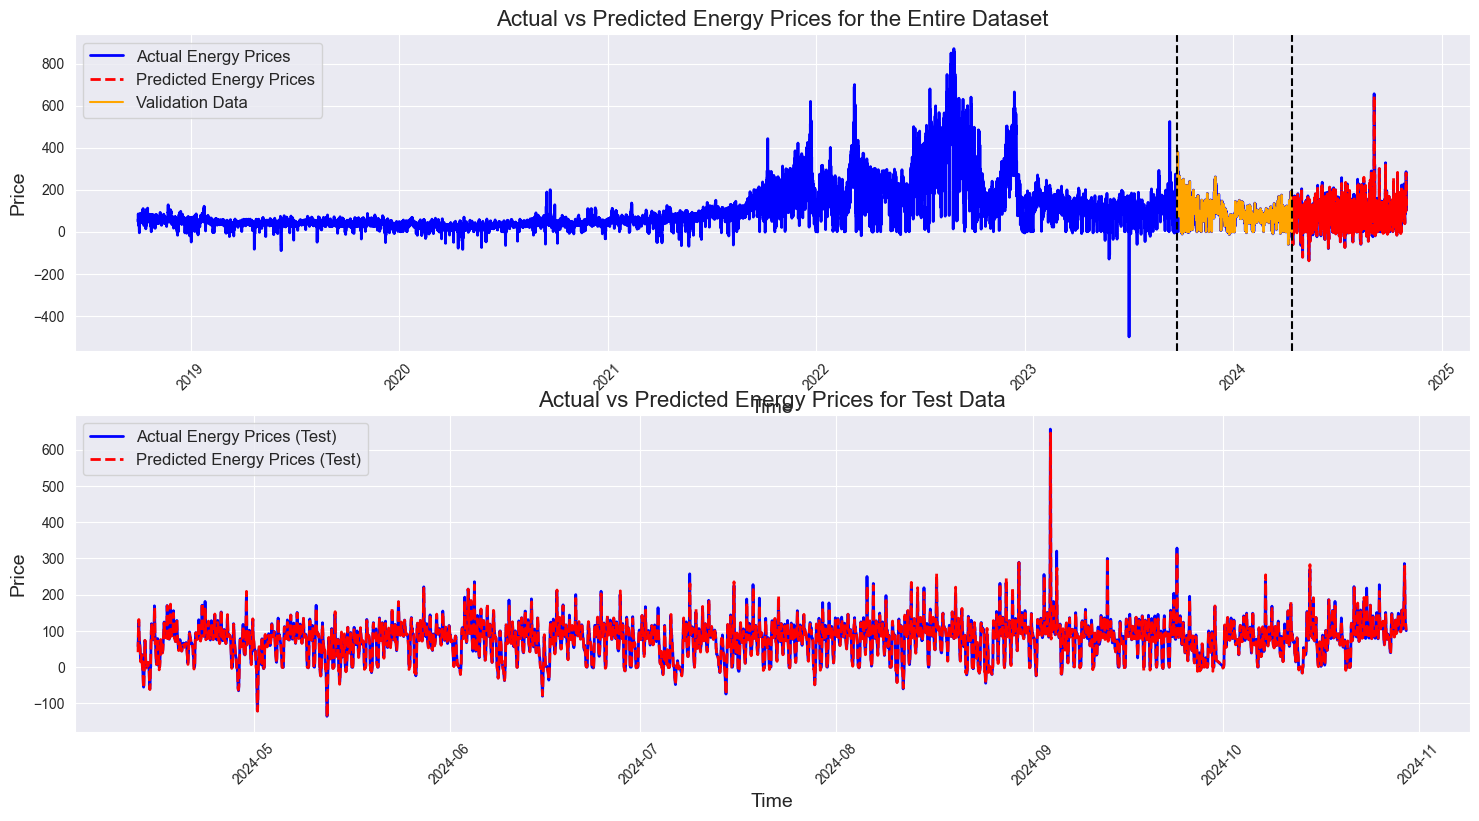

In [172]:
plt.figure(figsize=(18, 14))

# 1st Plot: Actual and predicted values for the entire dataset (training + test)
plt.subplot(3, 1, 1)
plt.plot(merged_data['ds'], merged_data['y'], label='Actual Energy Prices', color='blue', linewidth=2)
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Energy Prices', color='red', linestyle='dashed', linewidth=2)
plt.plot(validation_data['ds'], validation_data['y'], label='Validation Data', color='orange')
plt.axvline(x=train_data['ds'].iloc[-1], color='black', linestyle='--')
plt.axvline(x=validation_data['ds'].iloc[-1], color='black', linestyle='--')
plt.title("Actual vs Predicted Energy Prices for the Entire Dataset", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

# 2nd Plot: Actual and predicted values for only the test data
plt.subplot(3, 1, 2)
test_data = merged_data[test_split_index:]
plt.plot(test_data['ds'], test_data['y'], label='Actual Energy Prices (Test)', color='blue', linewidth=2)
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Energy Prices (Test)', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Predicted Energy Prices for Test Data", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)


### Grid Search for Best RMSE (after)

In [81]:
from sklearn.metrics import mean_squared_error
import numpy as np
from itertools import combinations

# Define the potential regressors
time_based_regressors = ['dayofweek', 'dayofyear']
moving_average_regressors = ['ma_3_hours', 'ma_6_hours', 'ma_12_hours', 'ma_1_days', 'ma_3_days']
energy_source_regressors = ['Biomass', 'Hard Coal', 'Hydro', 'Lignite', 'Natural Gas', 'Nuclear', 'Other',
                            'Pumped storage generation', 'Solar', 'Wind offshore', 'Wind onshore']
weather_regressors = ['temperature_2m', 'relative_humidity_2m', 'Precipitation (rain/snow)', 'surface_pressure',
                      'cloud_cover', 'wind_speed_100m', 'sunshine_duration', 'Global Horizontal Irradiance',
                      'direct_radiation']
moving_average_weather_energy_regressors = ['price_ma_12_hours', 'biomass_ma_12_hours', 'pumped_storage_generation_ma_12_hours',
                                            'hard_coal_ma_12_hours', 'lignite_ma_12_hours', 'natural_gas_ma_12_hours',
                                            'nuclear_ma_12_hours', 'other_ma_12_hours', 'solar_ma_12_hours',
                                            'wind_offshore_ma_12_hours', 'wind_onshore_ma_12_hours']

# Combine all possible regressors
all_regressors = time_based_regressors + moving_average_regressors + energy_source_regressors + weather_regressors + moving_average_weather_energy_regressors

# Function to calculate RMSE for a given set of regressors
def calculate_rmse(train_data, test_data, regressors):
    # Initialize the Prophet model with the given regressors
    model = Prophet()
    for reg in regressors:
        model.add_regressor(reg)

    # Fit the model
    model.fit(train_data)

    # Make predictions
    forecast = model.predict(test_data)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_data['y'], forecast['yhat']))
    return rmse

# Create all combinations of regressors (you can adjust the number of features to avoid too many combinations)
best_rmse = float('inf')
best_combination = None

# Iterate over combinations of regressors, up to a maximum number of regressors (to avoid computational overload)
for r in range(1, len(all_regressors) + 1):
    for comb in combinations(all_regressors, r):
        # Calculate RMSE for this combination
        rmse = calculate_rmse(train_data, test_data, comb)

        # Update the best RMSE and combination if we find a new best
        if rmse < best_rmse:
            best_rmse = rmse
            best_combination = comb

# Output the best combination of regressors and the corresponding RMSE
print(f"Best Combination of Regressors: {best_combination}")
print(f"Best RMSE: {best_rmse}")


22:30:31 - cmdstanpy - INFO - Chain [1] start processing
22:30:51 - cmdstanpy - INFO - Chain [1] done processing
22:30:53 - cmdstanpy - INFO - Chain [1] start processing
22:31:07 - cmdstanpy - INFO - Chain [1] done processing
22:31:09 - cmdstanpy - INFO - Chain [1] start processing
22:31:12 - cmdstanpy - INFO - Chain [1] done processing
22:31:14 - cmdstanpy - INFO - Chain [1] start processing
22:31:17 - cmdstanpy - INFO - Chain [1] done processing
22:31:19 - cmdstanpy - INFO - Chain [1] start processing
22:31:23 - cmdstanpy - INFO - Chain [1] done processing
22:31:25 - cmdstanpy - INFO - Chain [1] start processing
22:31:27 - cmdstanpy - INFO - Chain [1] done processing
22:31:29 - cmdstanpy - INFO - Chain [1] start processing
22:31:38 - cmdstanpy - INFO - Chain [1] done processing
22:31:40 - cmdstanpy - INFO - Chain [1] start processing
22:32:01 - cmdstanpy - INFO - Chain [1] done processing
22:32:03 - cmdstanpy - INFO - Chain [1] start processing
22:32:17 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

|with adding holiday, rmse: 17.9